In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from matplotlib import pyplot as plt

from numpy import cos, sin, arange, trace, pi, newaxis, sum, eye, array, mgrid, diag, prod
from numpy.linalg import norm, matrix_power
from numpy.random import randn, rand, seed

from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend, show, xlim, ylim, subplot, grid, savefig, imshow, colorbar, tight_layout, text, xticks, yticks, yscale

from data import FixedRot, Reshape
from trainer import Trainer
from model import Lconv_core
from generator import Generator
from mnist import MnistDataset

plt.rcParams['image.cmap']='seismic'



/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generator

In [3]:
DIM = 9

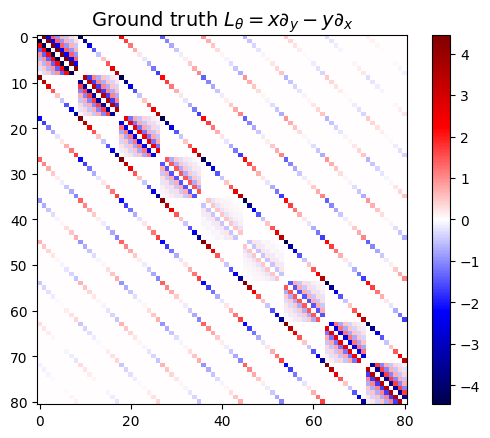

In [4]:
gen = Generator(dim = DIM)
L_rot = gen.xLy - gen.yLx

plt.imshow(L_rot)
plt.title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);
plt.colorbar();
plt.show()

### Data

In [5]:
# # download the dataset
# !wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
# # uncompress the zip file
# !unzip -n mnist.zip -d mnist

In [6]:
r = 45.
dim = DIM
N = None
train_dataset = MnistDataset(mode = 'train', r=r, dim=dim, N=N)
test_dataset = MnistDataset(mode = 'test', r=r, dim=dim, N=N)

In [7]:
len(test_dataset)

50000

In [8]:
idxs = np.where(train_dataset.labels == 5)[0]
train_dataset.labels = train_dataset.labels[idxs]
train_dataset.images = train_dataset.images[idxs]
train_dataset.images_rot = train_dataset.images_rot[idxs]

idxs = np.where(test_dataset.labels == 5)[0]
test_dataset.labels = test_dataset.labels[idxs]
test_dataset.images = test_dataset.images[idxs]
test_dataset.images_rot = test_dataset.images_rot[idxs]


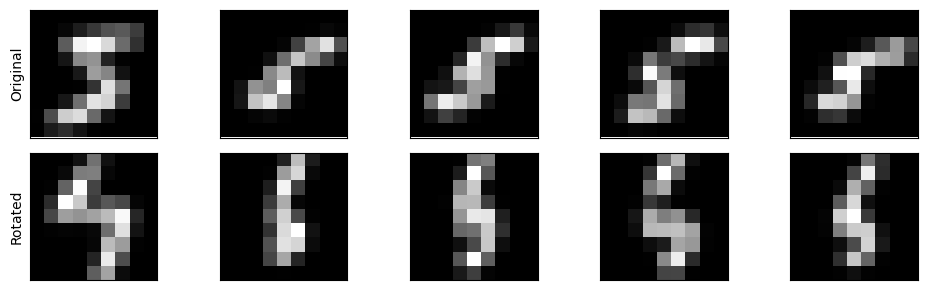

In [9]:
n_examples = 5

x = train_dataset[:n_examples][0].squeeze()
y = train_dataset[:n_examples][1].squeeze()

fig, axs = plt.subplots(2, n_examples, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
for i in range(5):
    axs[0, i].imshow(x[i], cmap = 'gray')
    axs[1, i].imshow(y[i], cmap = 'gray')
    axs[0, 0].set_ylabel('Original')
    axs[1, 0].set_ylabel('Rotated')

    for ax in axs:
        ax[i].set_xticks([])
        ax[i].set_yticks([])

plt.show()


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader_kwargs = {
    'batch_size': 128,
    'num_workers': 2,
    'pin_memory': True,
}

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True,  **dataloader_kwargs)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  shuffle=False, **dataloader_kwargs)

## Learning $L_\theta$ from small rotations
Now we learn $L_\theta$ from pairs of images where one has a small, fixed rotation relative to the other. 
This is simply using L-conv for linear regression, trained via SGD.
\begin{align}
    F(h) &= h+ L_ih\bar{\epsilon}^i %= (I+L_ihM^i)\cr
    %M^i &= W^i [\tilde{W}^0]^{-1}
\end{align}

In [11]:
s = train_dataset[0][0].shape
d = prod(s)
lc = Lconv_core(d=d,num_L=1, cin=1, cout=1)
model = nn.Sequential(
    nn.Flatten(2),
    lc,
    Reshape(s)
).to(device)

optimizer = optim.Adam(model.parameters(),lr = 1e-2)

t = Trainer(model, device, optimizer, train_loader=train_dataloader, test_loader=test_dataloader, 
            loss_func=F.mse_loss)

t.fit(epochs = 5)


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Text(0.5, 0, 'Epochs')

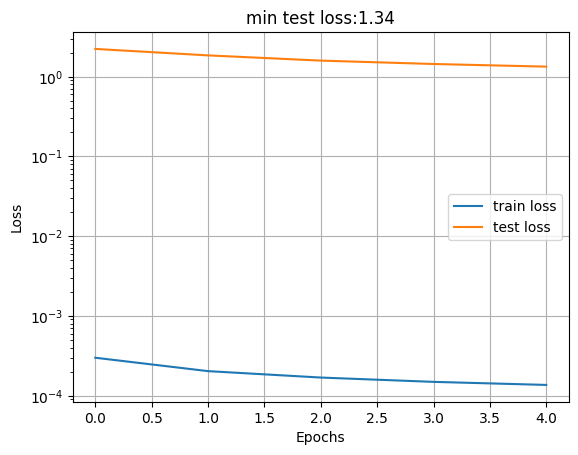

In [12]:
for k in ['train loss', 'test loss']:
    plot(t.history[k], label=k)
    
title(f'min test loss:{min(t.history["test loss"]):.3g}')
legend()
grid()
yscale('log')
ylabel('Loss')
xlabel('Epochs')

In [14]:
ang_n = r
ang = pi/ang_n
L_small = (lc.L*lc.Wi).detach().cpu().numpy()[0] / ang

In [16]:
(lc.L*lc.Wi).detach().cpu().numpy().shape

(1, 81, 81)

In [22]:
L_rot.shape, L_small.shape

(torch.Size([81, 81]), (81, 81))

In [24]:
nn.functional.mse_loss(L_rot.unsqueeze(0), torch.tensor(L_small).unsqueeze(0))

tensor(0.5445)

In [18]:
L_rot, L_small

(tensor([[ 0.0000,  4.4542, -2.1579,  ...,  0.0000,  0.0000,  0.0000],
         [-4.4542,  0.0000,  4.4542,  ...,  0.0000,  0.0000,  0.0000],
         [ 2.1579, -4.4542,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -3.4644,  1.6783],
         [ 0.0000,  0.0000,  0.0000,  ...,  3.4644,  0.0000, -3.4644],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.6783,  3.4644,  0.0000]]),
 array([[ 0.0366468 ,  0.14983363, -0.03551346, ...,  0.16439644,
          0.11623621,  0.04673605],
        [-0.08004576,  0.01831154,  0.01802598, ..., -0.08162972,
          0.06669451,  0.05343439],
        [ 0.18449406,  0.08251055, -0.09347454, ..., -0.04621657,
         -0.04043687, -0.06757063],
        ...,
        [-0.06857865, -0.15439652,  0.10351602, ..., -0.8655358 ,
         -0.8003814 , -0.0055698 ],
        [ 0.01589168, -0.05122873,  0.04991666, ..., -0.39013758,
         -0.5941976 , -0.06407715],
        [ 0.03012541, -0.05262692, 

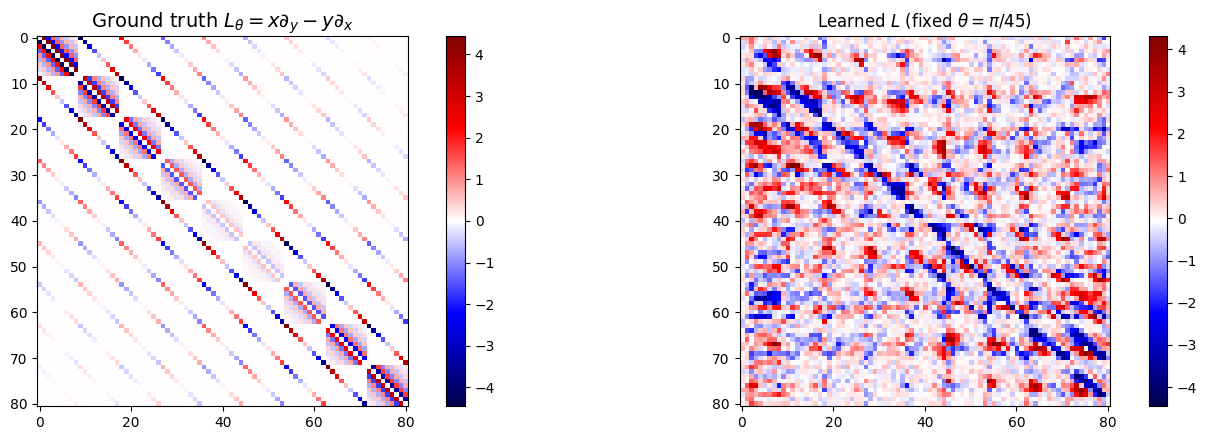

In [109]:
m = 3
vmin, vmax = -m, m
vmin, vmax = None, None

plt.figure(figsize=(10*3/2,3*3/2))
plt.subplot(121)
plt.title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);
plt.imshow(L_rot, vmin = vmin, vmax = vmax)
plt.colorbar()

plt.subplot(122)
plt.title(r'Learned $L$ (fixed $\theta=\pi/%d$)'%(ang_n))
plt.imshow(L_small, vmin = vmin, vmax = vmax)
plt.colorbar()

plt.tight_layout()